In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map,

In [2]:
rep_1 <- here(data_path,"zea_mays.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- here(data_path,"zea_mays.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [3]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3 x values <= 0 omitted from logarithmic plot"


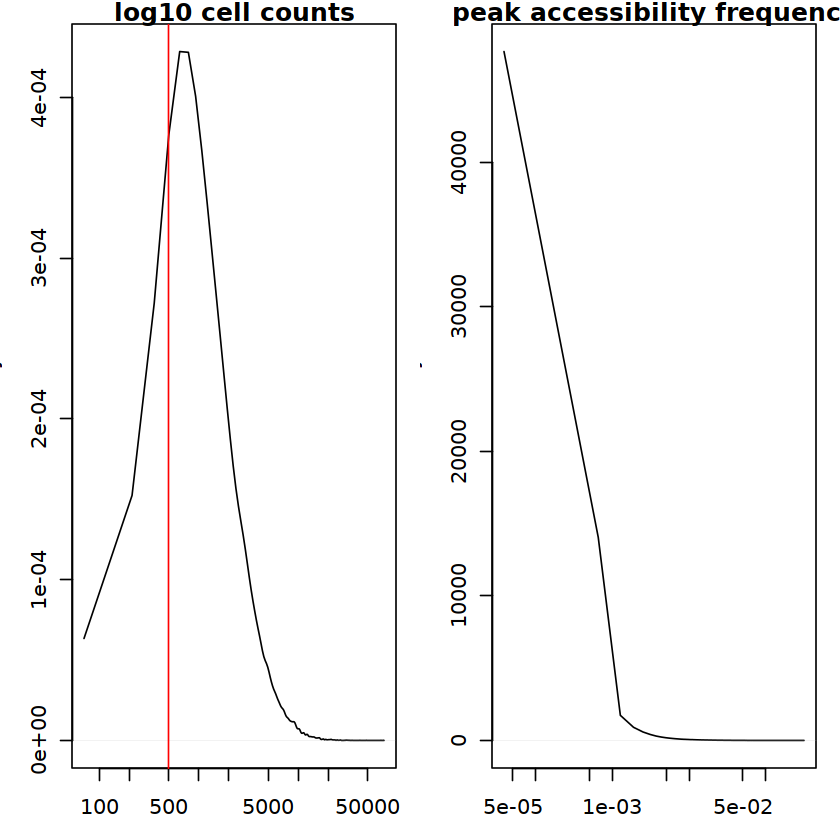

In [4]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [5]:
head(soc.obj$counts)

   [[ suppressing 34 column names 'BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1', 'BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1', 'BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1' ... ]]



6 x 17959 sparse Matrix of class "dgCMatrix"
                                                                              
chr1_10000001_10000500   . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_1000001_1000500     . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001_100500       . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001001_100001500 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001501_100002000 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100002001_100002500 . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                             
chr1_10000001_10000500   . . . . . . . ......
chr1_1000001_1000500     . . . . . . . ......
chr1_100001_100500       . . . . . . . ......
chr1_100001001_100001500 . . . . . . . ......
chr1_100001501_100002000 . . . . . . . ......
chr1_100002001_100002500 . . . . . . . ......

 .....suppressing 17925 columns in show(); maybe adjust 'options(max.print= *, 

In [6]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.008,  # minimum feature frequency across cells
                     max.t=0.2, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

   * Input: cells = 17959 | peaks = 2934334

   * Filtered: cells = 17188 | peaks = 48412



In [7]:
soc.obj$acr 

NULL

In [8]:
set.seed(8)
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=40000,
                      svd_slotName="SVD")

In [9]:
# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=40,
                       m.dist=0.1,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

15:23:25 UMAP embedding parameters a = 1.577 b = 0.8951

15:23:25 Read 17188 rows and found 29 numeric columns

15:23:25 Using Annoy for neighbor search, n_neighbors = 40

15:23:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:23:29 Writing NN index file to temp file /tmp/Rtmpv7VqPw/file14f34336d933

15:23:29 Searching Annoy index using 24 threads, search_k = 4000

15:23:30 Annoy recall = 100%

15:23:42 Commencing smooth kNN distance calibration using 24 threads

15:23:49 Initializing from normalized Laplacian + noise

15:23:51 Commencing optimization for 200 epochs, with 1073084 positive edges

15:24:43 Optimization finished



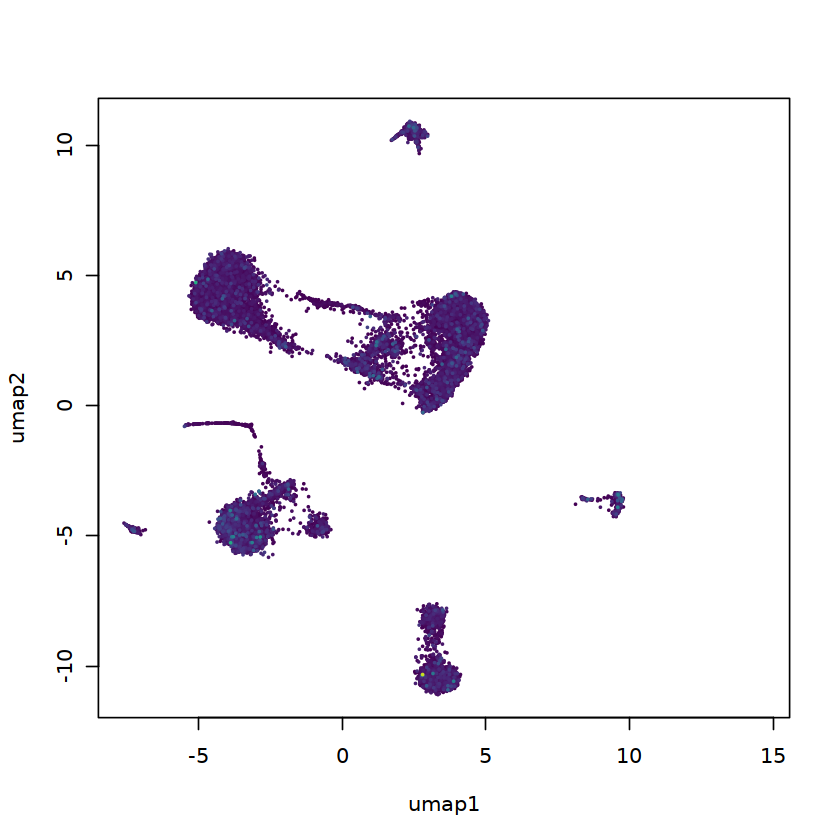

In [10]:
plotUMAP(soc.obj.project_umap, cex=0.3, column = "total")

In [11]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

 - Created 85000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [12]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [13]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [14]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

── Attaching packages ────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Socrates::p

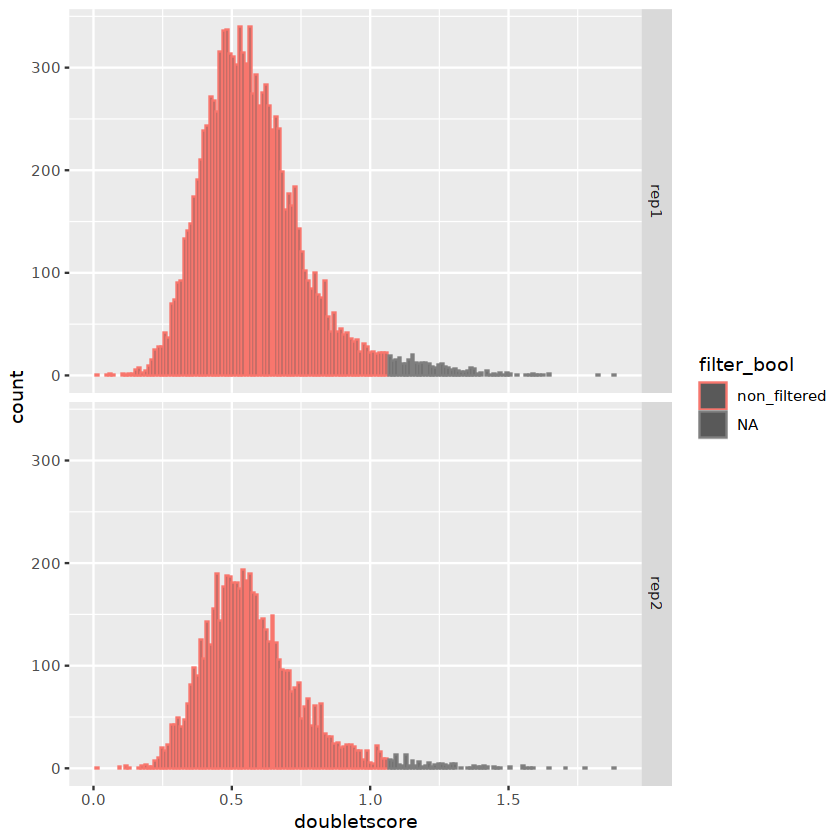

In [15]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

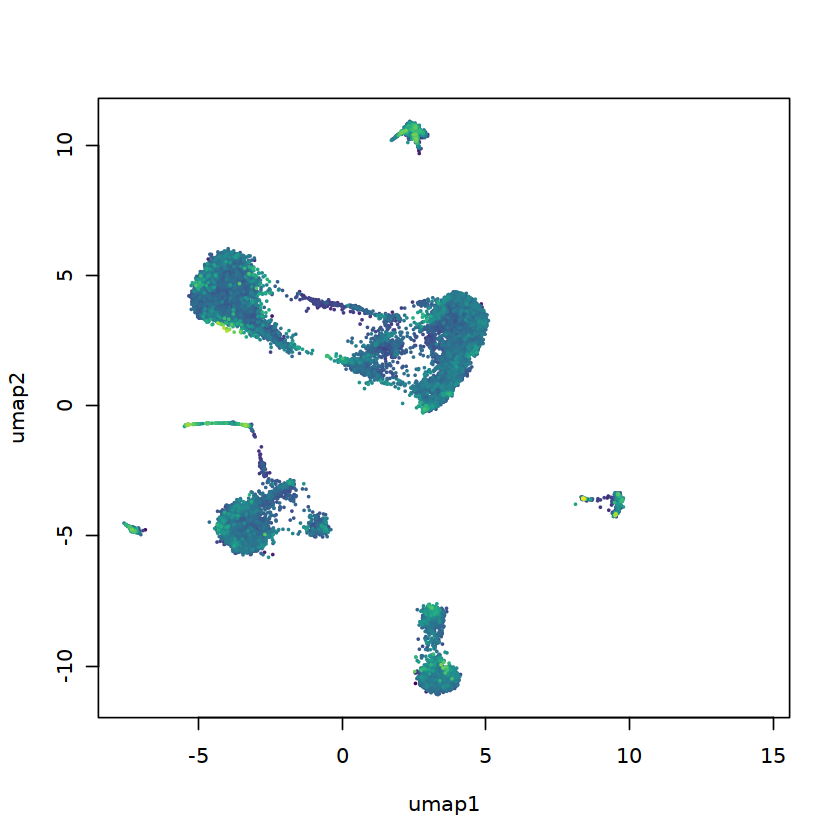

In [16]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "doubletscore")

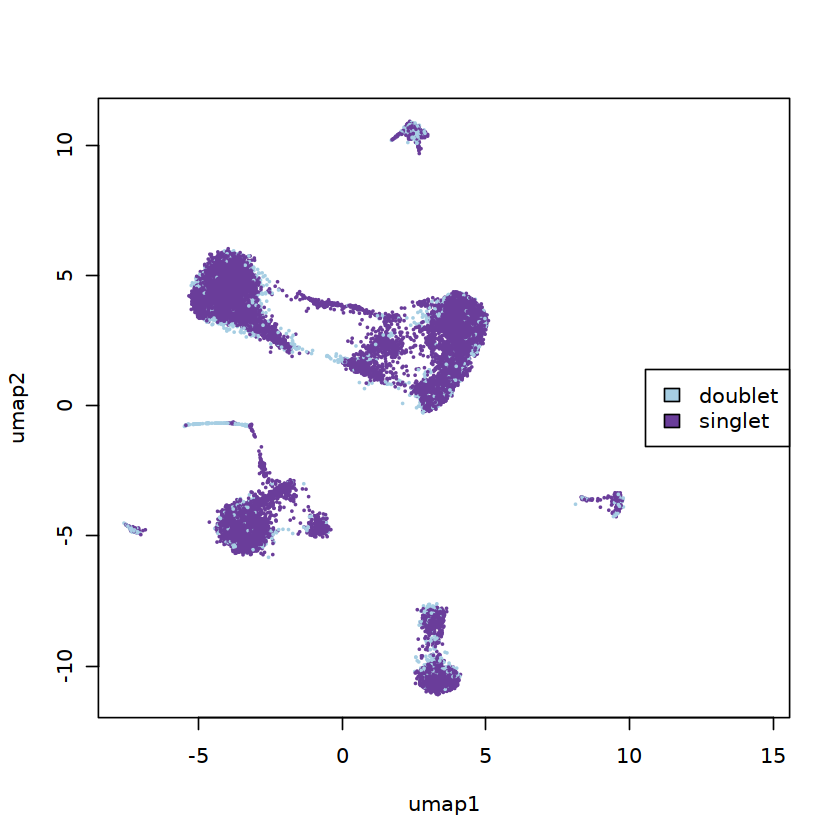

In [17]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [18]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [19]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

cellID,total,tss,acrs,ptmt,nSites,log10nSites,sampleID,umap1,umap2,doubletscore,d.type,filter_bool
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1,130500,30598,43932,NA,72161,4.858303,rep1,-3.191612,-4.012369,0.6705882,singlet,non_filtered
BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1,79068,27529,40483,NA,41701,4.620146,rep1,-5.100203,4.720831,1.1882353,doublet,filtered
BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1,66736,27423,46597,NA,33010,4.518646,rep1,-2.854333,-5.043575,0.7882353,doublet,non_filtered
BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1,55804,19968,31883,NA,29000,4.462398,rep1,-3.136630,-5.258085,0.4235294,singlet,non_filtered
BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1,53708,17311,26815,NA,30014,4.477324,rep1,3.878219,-10.579890,0.4470588,singlet,non_filtered
BC:Z:GTCCGCGGCTACAGCGAGAGTGGACCGG-Zm_rep1_P3_10x.rep1,51297,24619,42278,NA,24360,4.386677,rep1,-2.978713,-5.064385,0.6823529,singlet,non_filtered


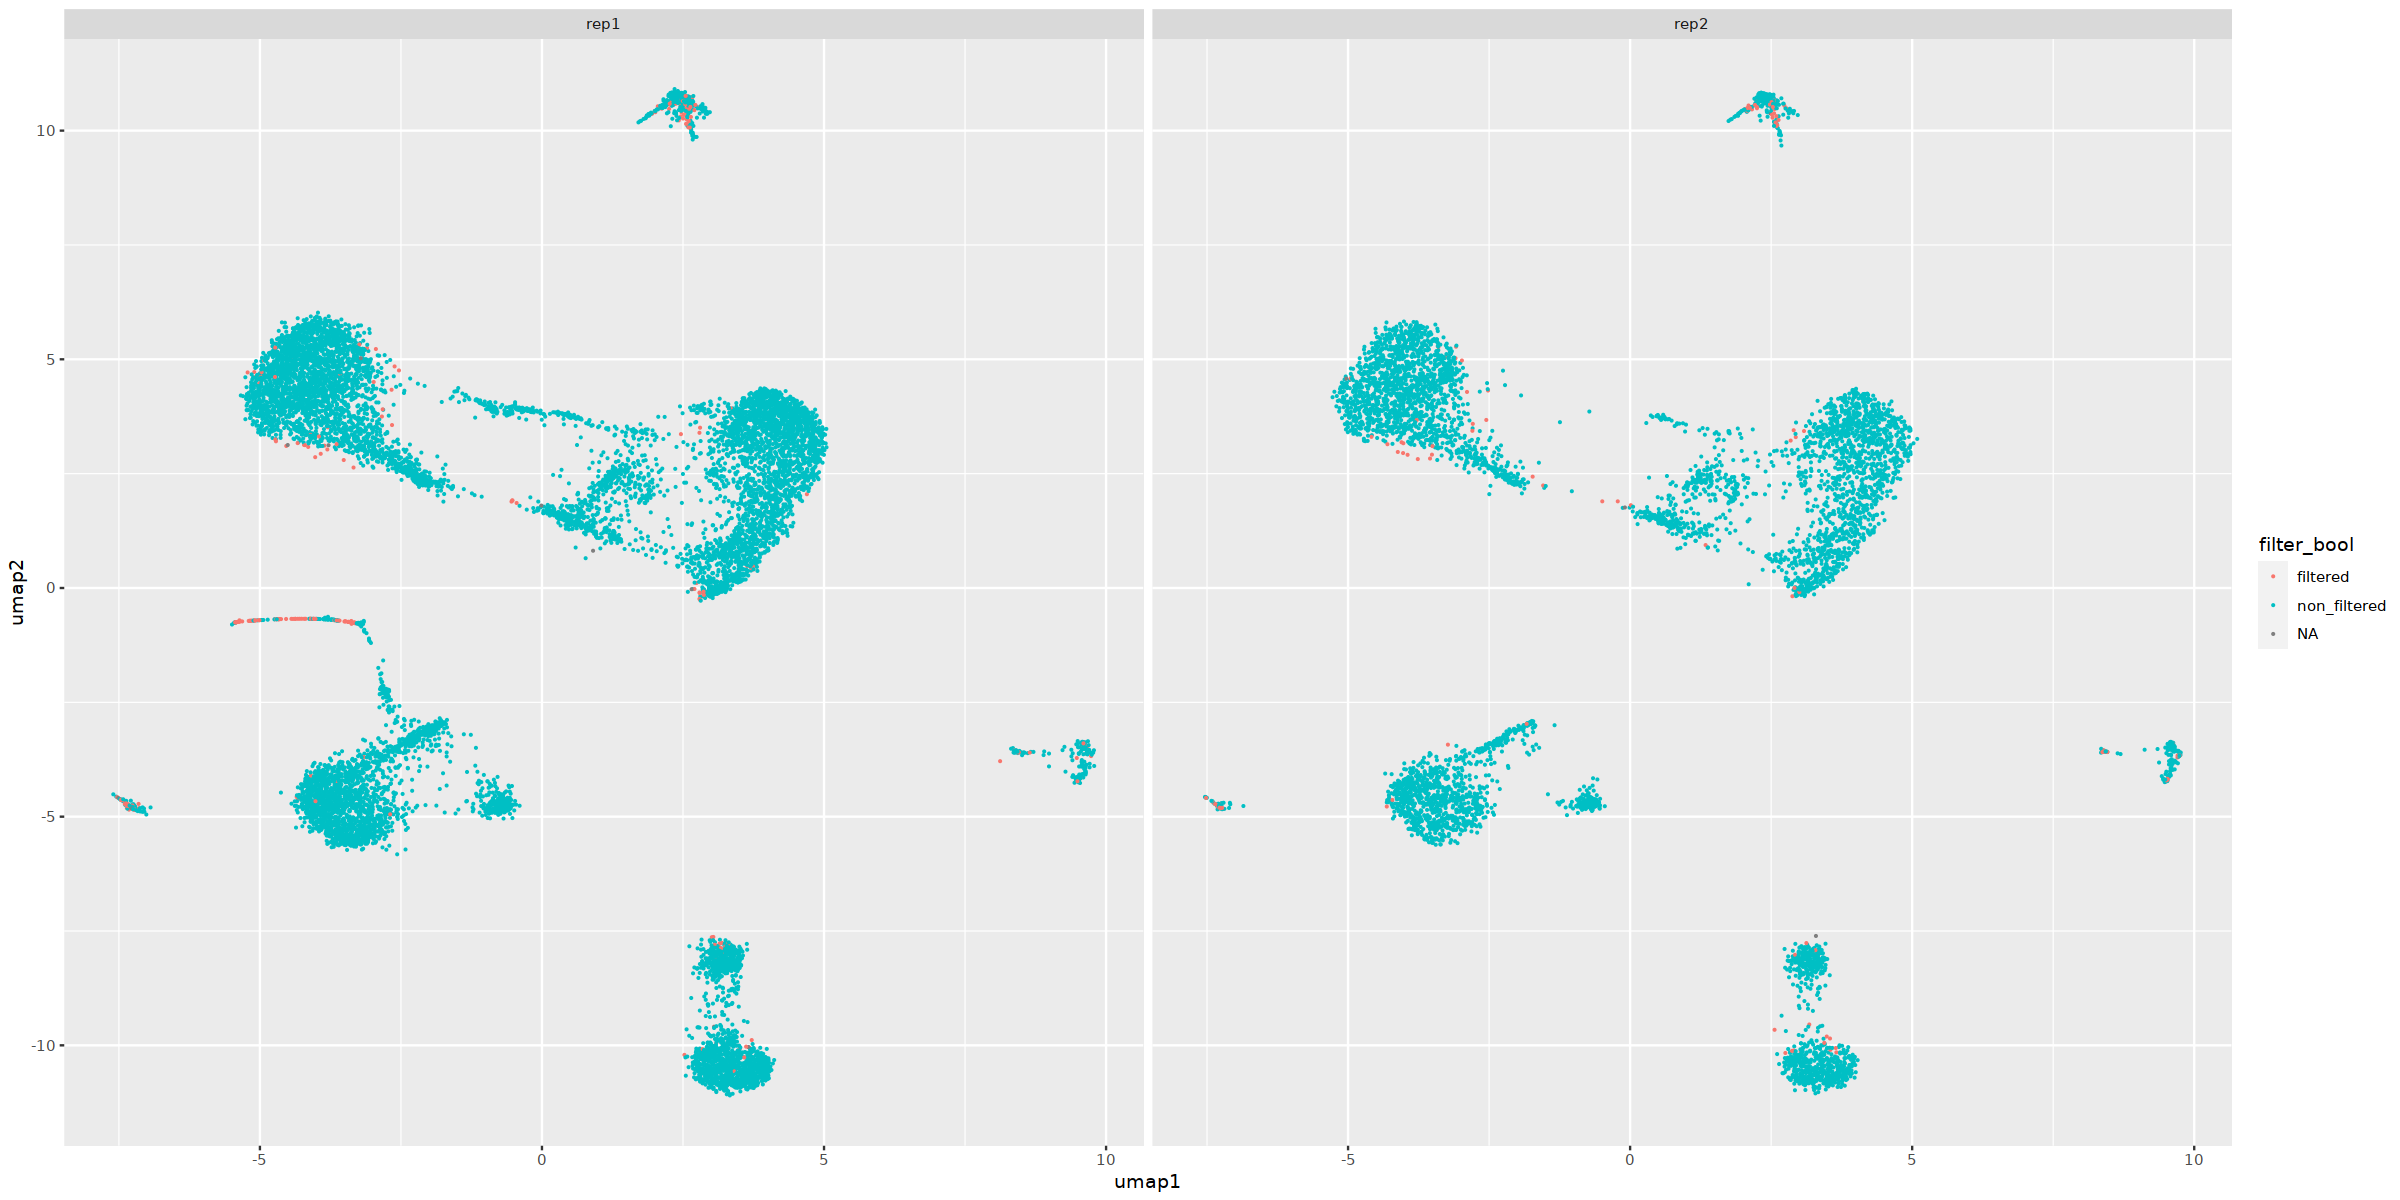

In [20]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

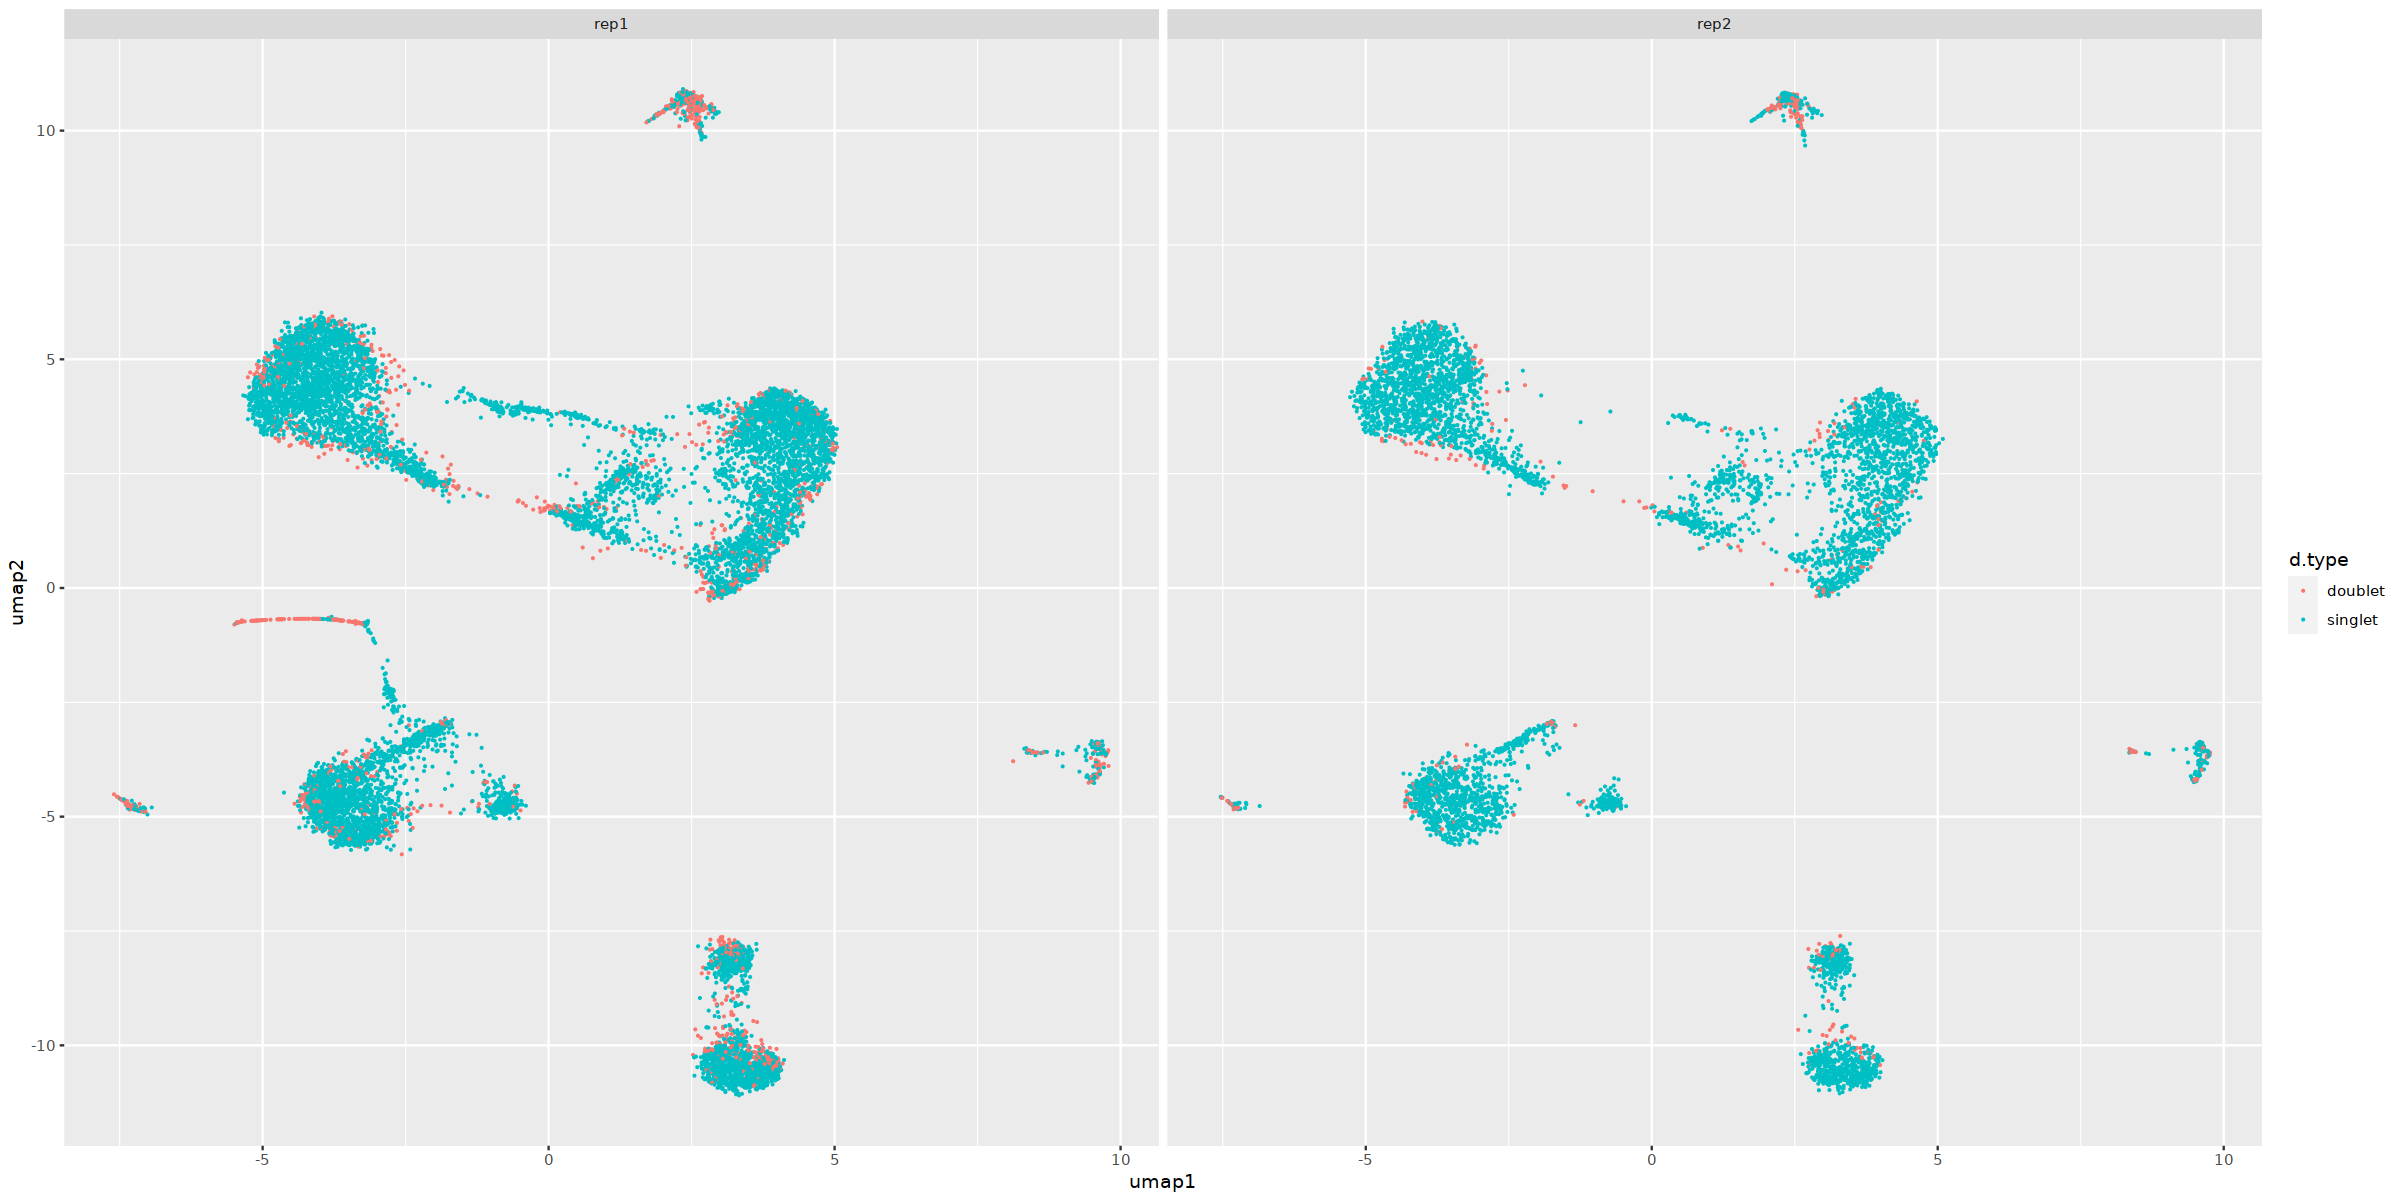

In [21]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = d.type)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [22]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 760  Filtered: cells = 16428 | peaks = 48412



In [23]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2.5,
                        verbose=T,
                        m.clst = 100,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16130
Number of edges: 992573

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7459
Number of communities: 21
Elapsed time: 72 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 15696

 - filtering clusters with low cell/read counts ...



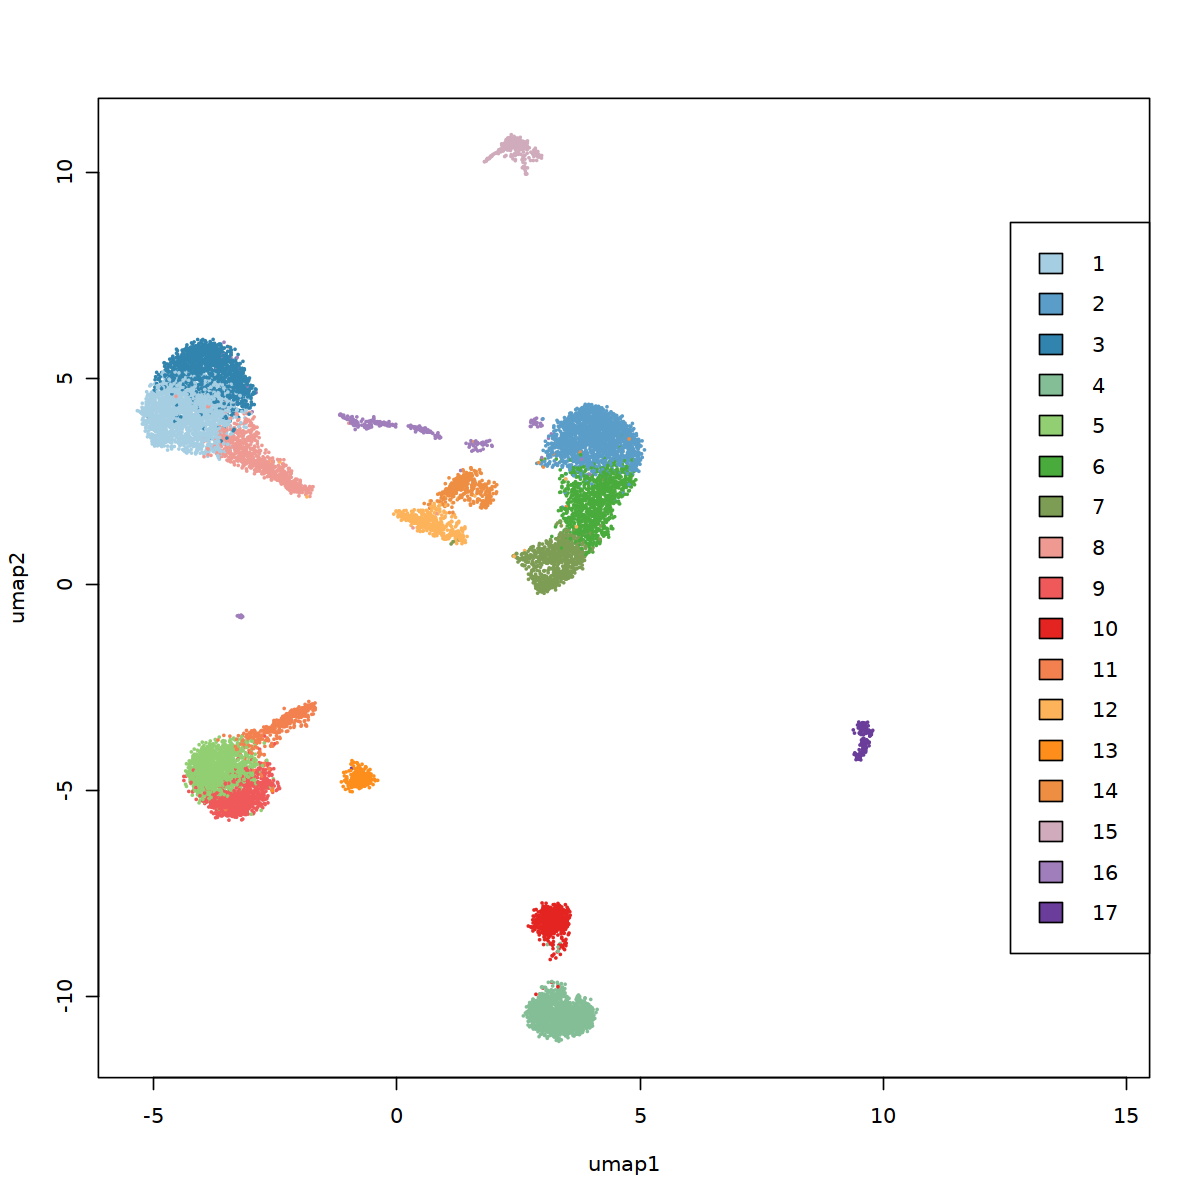

In [24]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

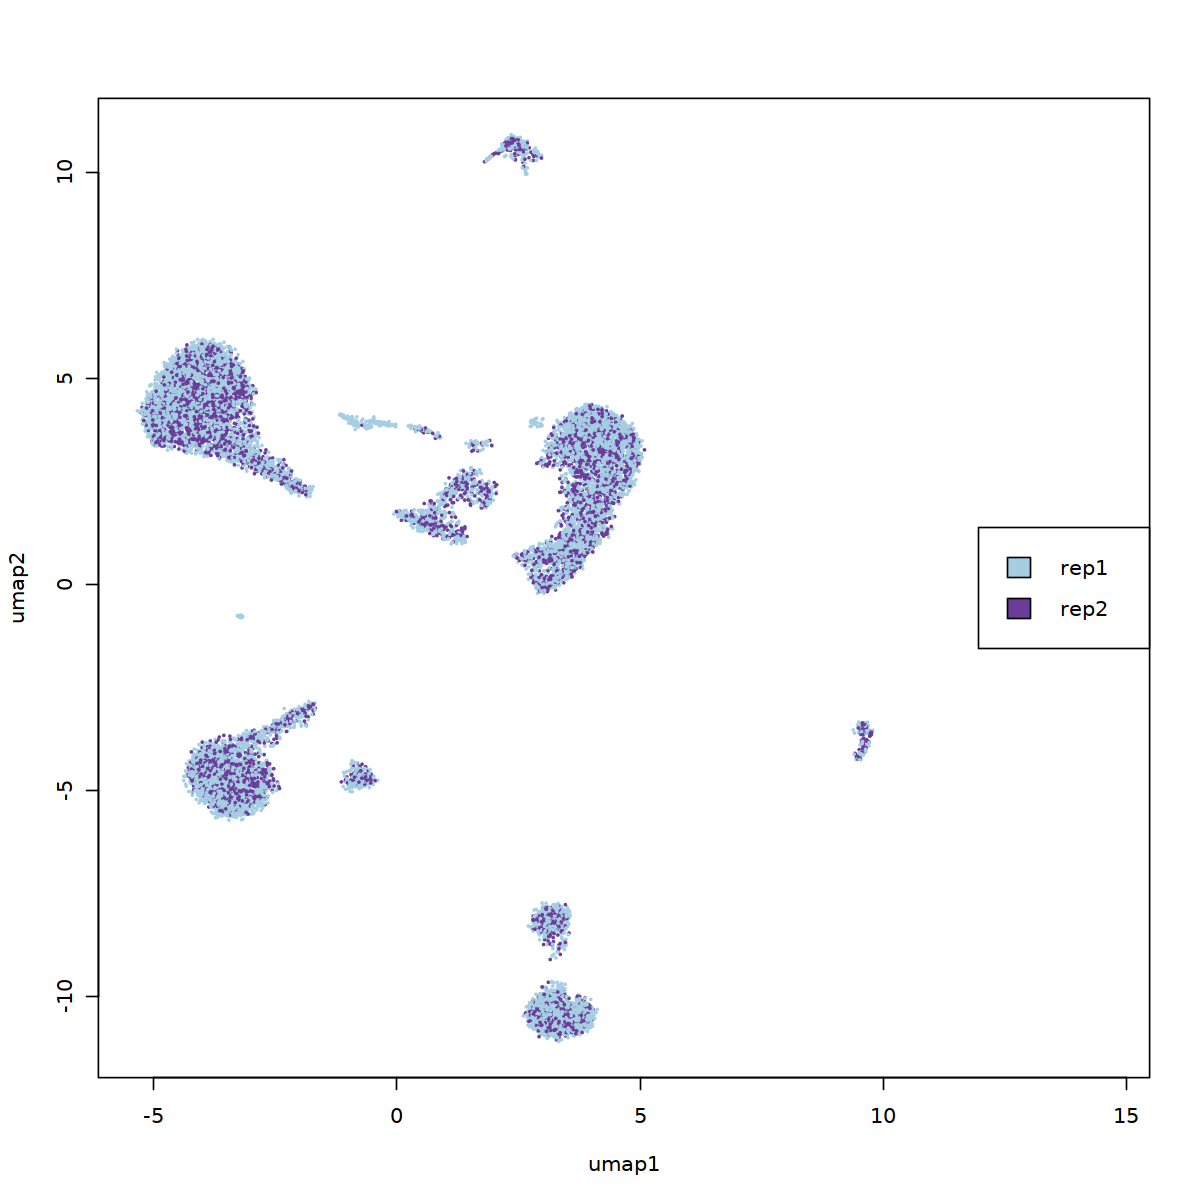

In [25]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [26]:
genotype_doublet_detection <- read_tsv("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_Mo17B73_P2_G031_10x.rep1.doublet_genotypes.txt", col_names = TRUE)  %>% 
    filter(final_cell_assignment == "Doublet")
sum(genotype_doublet_detection$cellID %in% tfidf.obj.dob.filt.clusters$Clusters$cellID)
remove_vector <- as.vector(genotype_doublet_detection$cellID)

Rows: 746 Columns: 37
── Column specification ───────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): cellID, BARCODE, DROPLET.TYPE, BEST.GUESS, NEXT.GUESS, SNG.BEST.GU...
dbl (26): total.x, tss.x, acrs.x, nSites.x, log10nSites.x, umap1, umap2, Lou...
lgl  (2): ptmt.x, ptmt.y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 3

In [27]:
remove_cell_IDs <- function(obj, cell_ID_names_rm) { 

    old_meta <- obj$Clusters
    
    new_meta <- old_meta[!old_meta$cellID %in% cell_ID_names_rm, ] 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

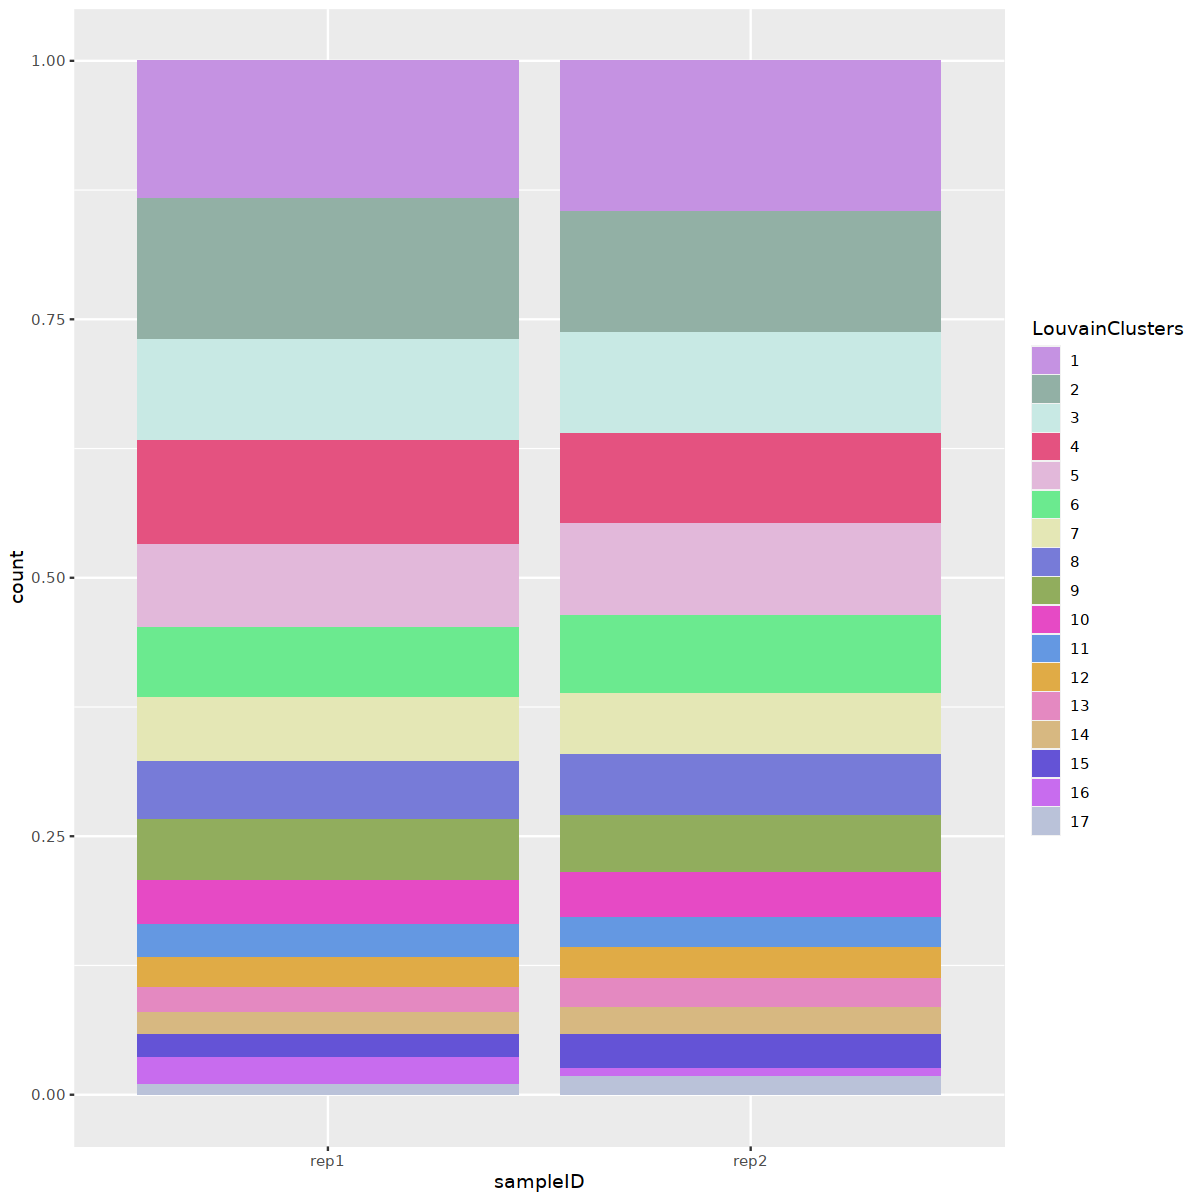

In [28]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [29]:
final_removed_genotype_doublets <- remove_cell_IDs(tfidf.obj.dob.filt.clusters,remove_vector)

   * Doublet filtering * Number cells removed= 3  Filtered: cells = 15317 | peaks = 48412



In [30]:
cleaned_cluster <- final_removed_genotype_doublets$Clusters  %>% 
    mutate(LouvainCluster_t = str_c("Louvain_c", LouvainClusters))

final_removed_genotype_doublets$Clusters <- cleaned_cluster

In [53]:
call_per_cluster_ACRs <- function(meta_obj, 
                                  slot_name, 
                                  cluster_name, 
                                  bed_integrations, 
                                  base_output_name="test_Rrun", 
                                  output_dir="test", 
                                  genome_file,
                                  verbose=FALSE){
    
    clust_name <- c(cluster_name)
    
    cell_converted_trible <- as_tibble(meta_obj[[slot_name]])
    
    
    generate_count_data <- cell_converted_trible  %>% 
        group_by(!!sym(clust_name))  %>% 
        summarise(counts_per_clust = n())
    
    print(generate_count_data)
    
    final_tribble <- left_join(cell_converted_trible, generate_count_data)  %>% 
        mutate(cluster_name_final = str_c(!!sym(clust_name), "_ncell_", counts_per_clust))

    
    write_delim(final_tribble, "test_output_name.2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

    if(verbose){message("Calling peaks for Clusters - This may take some time. Check output terminal for info.")}
    generate_run_command = paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed ", bed_integrations, 
                                  " -meta ", "test_output_name.2.txt", 
                                  " -col ", "cluster_name_final", 
                                  " -base ", base_output_name, 
                                  " -outdir ", output_dir, 
                                  " -bw yes -fai ", genome_file)
    
    print(generate_run_command)
    system(generate_run_command)

    
    if(verbose){message("Done!")}
    
    output_peak_file_name <- paste0(output_dir, "/", base_output_name, ".500bp_peaks.bed")
    
    meta_obj$acr_file_name <- output_peak_file_name
    return(meta_obj)
    
}

calculate_accessability <- function(meta_obj, 
                                    tn5_integration, 
                                    base_name="idk",
                                    bed_file_load = "acr_file_name",
                                    type = "acr",
                                    output_name="raw_accessability", 
                                    output_slot = "acr_counts_raw",
                                    output_dir = "."){
    
    peaks <- meta_obj[[bed_file_load]]
    final_output_name <- paste0(output_dir, "/", output_name)
    calculate_accessability <- paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno ", peaks, 
                                      " -tn5 ", tn5_integration," -type ", type, " -base ", base_name, " -p 10 -o ", final_output_name) 
    
    
    print(calculate_accessability)
    return_code <- system(calculate_accessability,intern = TRUE)
    
    meta_obj[output_slot] <- output_name
    
    return(meta_obj)
    
}

library(tidyverse)
library(devtools)
library(edgeR)
library('presto')
library(data.table)

library(tidyverse)
library('presto')
library(Matrix)

run_presto <- function(meta_obj, 
                       meta_slot, 
                       cluster_name, 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    clust_name <- c(cluster_name)

        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        dplyr::filter(gene_name != "Annotation")  %>%
        dplyr::filter(gene_name %in% meta_data$cellID)  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name) != TRUE))  %>% 
        arrange(!!sym(cluster_name))
    
    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcode <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcode)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcode))


    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))

    garbbed_louv_order <- as.vector(barcode_tibble[, cluster_name])
    print(dim(UIMatrix))
    print(dim(garbbed_louv_order))
    
    
    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj["presto_marker"] <- sparse_matrix_test
    
    return(meta_obj)
}



In [32]:
setwd("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering")
bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0.fa.fai"

In [33]:
final_removed_genotype_doublets$Clusters

,cellID,total,tss,acrs,ptmt,nSites,log10nSites,sampleID,umap1,umap2,doubletscore,d.type,LouvainClusters,LouvainCluster_t
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>
BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1,BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1,130500,30598,43932,NA,72161,4.858303,rep1,-3.1916122,-4.012369,0.6705882,singlet,5,Louvain_c5
BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1,BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1,66736,27423,46597,NA,33010,4.518646,rep1,-2.8543329,-5.043575,0.7882353,singlet,9,Louvain_c9
BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1,BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1,55804,19968,31883,NA,29000,4.462398,rep1,-3.1366300,-5.258085,0.4235294,singlet,9,Louvain_c9
BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1,BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1,53708,17311,26815,NA,30014,4.477324,rep1,3.8782187,-10.579890,0.4470588,singlet,4,Louvain_c4
BC:Z:GTCCGCGGCTACAGCGAGAGTGGACCGG-Zm_rep1_P3_10x.rep1,BC:Z:GTCCGCGGCTACAGCGAGAGTGGACCGG-Zm_rep1_P3_10x.rep1,51297,24619,42278,NA,24360,4.386677,rep1,-2.9787134,-5.064385,0.6823529,singlet,9,Louvain_c9
BC:Z:GAGTGGTAGCTTGTCCTGTAGAGACTAA-Zm_rep1_P8_10x.rep1,BC:Z:GAGTGGTAGCTTGTCCTGTAGAGACTAA-Zm_rep1_P8_10x.rep1,51177,10671,14377,NA,30752,4.487873,rep1,3.1592628,-10.283592,0.4705882,singlet,4,Louvain_c4
BC:Z:GTGAAAAGTCAAAAACAGTAGAGACTAA-Zm_rep1_P4_10x.rep1,BC:Z:GTGAAAAGTCAAAAACAGTAGAGACTAA-Zm_rep1_P4_10x.rep1,47683,15045,24942,NA,26418,4.421900,rep1,1.1998101,2.441007,0.7294118,singlet,14,Louvain_c14
BC:Z:GTCCGCGGCTACACCCCGTCCGCAACAT-Zm_rep1_P3_10x.rep1,BC:Z:GTCCGCGGCTACACCCCGTCCGCAACAT-Zm_rep1_P3_10x.rep1,45180,14244,22771,NA,25560,4.407561,rep1,-3.6805705,-4.344358,0.4705882,singlet,5,Louvain_c5
BC:Z:GTAGAGAGTCAAAGCGAGTGGCCTCGGA-Zm_rep1_P2_10x.rep1,BC:Z:GTAGAGAGTCAAAGCGAGTGGCCTCGGA-Zm_rep1_P2_10x.rep1,44910,19879,34718,NA,24623,4.391341,rep1,2.3227443,10.725865,0.6941176,singlet,15,Louvain_c15


In [38]:
tfidf.obj.dob.filt.clusters <- call_per_cluster_ACRs(final_removed_genotype_doublets, 
                                                     slot_name = "Clusters", 
                                                     cluster_name = "LouvainCluster_t",
                                                     bed_integrations = bed_intersections,
                                                     base_output_name = "Zm.V3_annot",
                                                     output_dir = "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/Zm.Louvain_cluster", 
                                                     genome_file= genome_file)

# A tibble: 17 × 2
   LouvainCluster_t counts_per_clust
   <chr>                       <int>
 1 Louvain_c1                   2108
 2 Louvain_c10                   662
 3 Louvain_c11                   472
 4 Louvain_c12                   450
 5 Louvain_c13                   388
 6 Louvain_c14                   362
 7 Louvain_c15                   393
 8 Louvain_c16                   299
 9 Louvain_c17                   195
10 Louvain_c2                   1984
11 Louvain_c3                   1496
12 Louvain_c4                   1468
13 Louvain_c5                   1280
14 Louvain_c6                   1081
15 Louvain_c7                    928
16 Louvain_c8                    874
17 Louvain_c9                    880


Joining, by = "LouvainCluster_t"


[1] "python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed -meta test_output_name.2.txt -col cluster_name_final -base Zm.V3_annot -outdir /scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/Zm.Louvain_cluster -bw yes -fai /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0.fa.fai"


In [39]:
tfidf.obj.dob.filt.clusters$gene_bed_file <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed"

In [40]:
tfidf.obj.dob.filt.clusters <- calculate_accessability(tfidf.obj.dob.filt.clusters,
                                                      tn5_integration= bed_intersections,
                                                       base_name = "Zm.LC_GeneAccessability",
                                                       bed_file_load = "gene_bed_file", 
                                                       type = "gene",
                                                       output_name="Zm.LC_GeneAccessability.txt", 
                                                       output_slot = "gene_acc_counts")

[1] "python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed -tn5 /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed -type gene -base Zm.LC_GeneAccessability -p 10 -o ./Zm.LC_GeneAccessability.txt"


In [41]:
str(tfidf.obj.dob.filt.clusters)

List of 16
 $ meta            :'data.frame':	15317 obs. of  13 variables:
  ..$ cellID         : chr [1:15317] "BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1" "BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1" "BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1" "BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1" ...
  ..$ total          : num [1:15317] 130500 66736 55804 53708 51297 ...
  ..$ tss            : num [1:15317] 30598 27423 19968 17311 24619 ...
  ..$ acrs           : num [1:15317] 43932 46597 31883 26815 42278 ...
  ..$ ptmt           : num [1:15317] NA NA NA NA NA NA NA NA NA NA ...
  ..$ nSites         : num [1:15317] 72161 33010 29000 30014 24360 ...
  ..$ log10nSites    : num [1:15317] 4.86 4.52 4.46 4.48 4.39 ...
  ..$ sampleID       : chr [1:15317] "rep1" "rep1" "rep1" "rep1" ...
  ..$ umap1          : num [1:15317] -3.19 -2.85 -3.14 3.88 -2.98 ...
  ..$ umap2          : num [1:15317] -4.01 -5.04 -5.26 -10.58 -5.06 ...
  ..$ doubletscore   : num [

In [54]:
tfidf.obj.dob.filt.clusters.counts.final <- run_presto(tfidf.obj.dob.filt.clusters,
           meta_slot = "Clusters",
           counts_raw = "gene_acc_counts",
           cluster_name = "LouvainCluster_t")

# A tibble: 6 × 3
  gene_name       barcode                                          accessability
  <chr>           <chr>                                                    <dbl>
1 Zm00001eb024370 BC:Z:AGTCAACTTGTAAGCGAGTTTCGTTCCC-Zm_rep2_P4_10…             2
2 Zm00001eb024370 BC:Z:AGTTCCCTTGTAATACGGTGAAAACTAA-Zm_rep2_P5_10…             2
3 Zm00001eb024370 BC:Z:CCGTCCAGTCAAAGCGACGTACGTCATT-Zm_rep1_P1_10…             2
4 Zm00001eb024370 BC:Z:CCGTCCAGTCAACCGAGGGTAGCTCGGA-Zm_rep1_P1_10…             2
5 Zm00001eb024370 BC:Z:CCGTCCTAGCTTACCCCATTCCTACTAA-Zm_rep1_P1_10…             2
6 Zm00001eb024370 BC:Z:CTTGTACTTGTAAGCGAATTCCTACTAA-Zm_rep2_P3_10…             2


ERROR: Error in (function (cl, name, valueClass) : assignment of an object of class "numeric" is not valid for @'Dim' in an object of class "dgTMatrix"; is(value, "integer") is not TRUE


In [ ]:
str(tfidf.obj.dob.filt.clusters.counts.final)